In [92]:
# set up the environment
%pylab
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import seaborn as sns
sns.set()
import pandas as pd
import scipy as sp
import scipy.stats
import statsmodels.stats.api as sms
import statsmodels.api as sm
import statsmodels.formula.api as smf
from arch.bootstrap import IIDBootstrap
import seaborn as sns

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


/Users/kallus/Applications/anaconda2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f', 'interactive']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [93]:
from ipywidgets import interact, interactive, fixed, interact_manual


In [101]:
xx=np.arange(-20,20,.1)
@interact(muhat=(0,10),n=(1,20),sigma=(1,10))
def doplots(muhat,n,sigma):
    for b in [1,5,10]:
        plot(xx,sp.stats.norm.pdf(xx,loc=0,scale=np.sqrt(b*b+sigma*sigma/n)),label='b=%d'%b)
    axvline(x=muhat,linestyle='-.',color='r')
    legend()



A Jupyter Widget

In [102]:
bb=np.logspace(0,3,100)
@interact(muhat=(0,10),n=(1,20),sigma=(1,10))
def doplots(muhat,n,sigma):
    plot(bb,sp.stats.norm.pdf(muhat,loc=0,scale=np.sqrt(bb*bb+sigma*sigma/n)))
    xscale('log')
    yscale('log')



A Jupyter Widget

In [103]:
xx=np.arange(-1,1,.01)
xxouter = np.outer(xx,xx)
xxdiff  = np.subtract.outer(xx,xx)
@interact(b=(0.1,1.5,.01),seed=(0,1000))
def doplots(b,seed):
    np.random.seed(seed)
    v = np.random.randn(len(xx))
    Ks = {
        'lin':xxouter/b/b,
        'quad':(1.+xxouter/b/b)**2-1,
        'cub':(1.+xxouter/b/b)**3-1,
        'rbf':np.exp(-xxdiff**2/b/b)
    }
    for k,K in Ks.iteritems():
        plot(xx,sp.linalg.sqrtm(K).dot(v),label=k)
    legend()


A Jupyter Widget

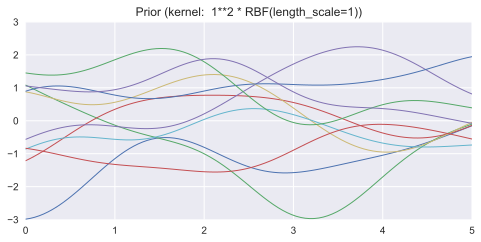

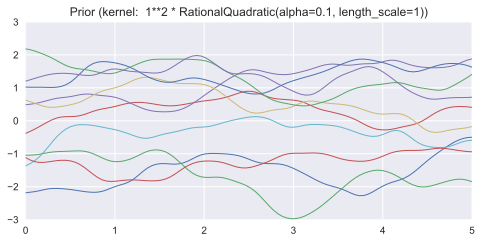

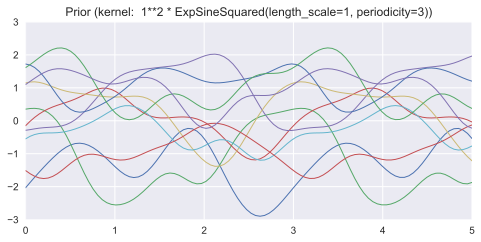

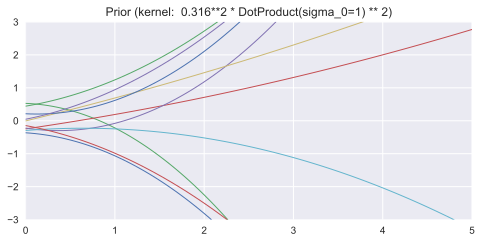

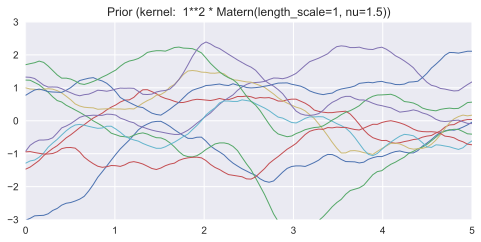

In [97]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,
                                              ExpSineSquared, DotProduct,
                                              ConstantKernel)
kernels = [1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0)),
           1.0 * RationalQuadratic(length_scale=1.0, alpha=0.1),
           1.0 * ExpSineSquared(length_scale=1.0, periodicity=3.0,
                                length_scale_bounds=(0.1, 10.0),
                                periodicity_bounds=(1.0, 10.0)),
           ConstantKernel(0.1, (0.01, 10.0))
               * (DotProduct(sigma_0=1.0, sigma_0_bounds=(0.0, 10.0)) ** 2),
           1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0),
                        nu=1.5)]

for fig_index, kernel in enumerate(kernels):
    # Specify Gaussian Process
    gp = GaussianProcessRegressor(kernel=kernel)
    # Plot prior
    plt.figure(fig_index, figsize=(8, 8))
    plt.subplot(2, 1, 1)
    X_ = np.linspace(0, 5, 100)
    y_samples = gp.sample_y(X_[:, np.newaxis], 10)
    plot(X_, y_samples, lw=1)
    xlim(0, 5)
    ylim(-3, 3)
    title("Prior (kernel:  %s)" % kernel, fontsize=12)



Text(0.5,1,u'function to predict')

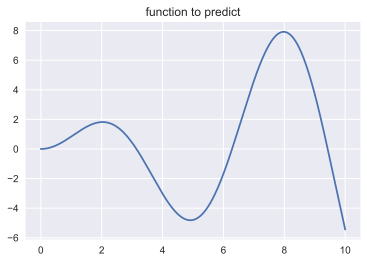

In [98]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

def f(x):
    return x * np.sin(x)

x = np.atleast_2d(np.linspace(0, 10, 1000)).T

plot(x,f(x))
title('function to predict')

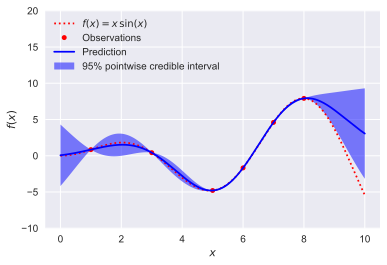

In [99]:
X = np.atleast_2d([1., 3., 5., 6., 7., 8.]).T
y = f(X).ravel()

kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sigma = gp.predict(x, return_std=True)

# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
fig = plt.figure()
plt.plot(x, f(x), 'r:', label=u'$f(x) = x\,\sin(x)$')
plt.plot(X, y, 'r.', markersize=10, label=u'Observations')
plt.plot(x, y_pred, 'b-', label=u'Prediction')
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% pointwise credible interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(-10, 20)
plt.legend(loc='upper left')


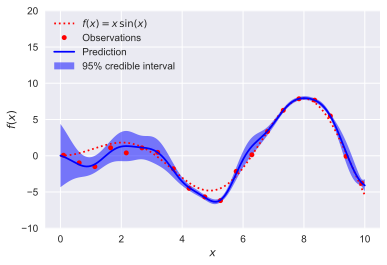

In [100]:
X = np.linspace(0.1, 9.9, 20)
X = np.atleast_2d(X).T

y = f(X).ravel()
dy = np.ones_like(y)#0.5 + 1.0 * np.random.random(y.shape)
noise = 1*np.random.normal(0, dy)
y += noise

# Instanciate a Gaussian Process model
kernel = C(1.0, (1e-1, 1e1)) * RBF(1, (1e-1, 1e1))
gp = GaussianProcessRegressor(kernel=kernel, alpha=(dy / y) ** 2,
                              n_restarts_optimizer=10)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sigma = gp.predict(x, return_std=True)

# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
fig = plt.figure()
plt.plot(x, f(x), 'r:', label=u'$f(x) = x\,\sin(x)$')
plt.plot(X.ravel(), y, 'r.', markersize=10, label=u'Observations')
plt.plot(x, y_pred, 'b-', label=u'Prediction')
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% credible interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(-10, 20)
plt.legend(loc='upper left')

plt.show()
